### Evaluasi & Analisis Sistem Rekomendasi Sitasi + Dosbing (UDINUS)

- Ringkasan dataset (tabel + contoh data)
- Grafik EDA (tahun, source, panjang abstrak)
- Preprocessing (before/after)
- **BM25** retrieval untuk sitasi (dengan *evidence sentence* + highlight token)
- **TF-IDF + Cosine** untuk rekomendasi dosbing
- Template evaluasi (Precision@K, nDCG@K, Hit@K, MRR)


#### Setup & Konfigurasi


In [40]:
from pathlib import Path
import json
import math
import re
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

DATA_PATH = Path("data/interim/parsed_docs.jsonl")
OUT_DIR = Path("outputs")
FIG_DIR = OUT_DIR / "figures"
OUT_DIR.mkdir(exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

pd.set_option("display.max_colwidth", 120)
print("DATA_PATH exists:", DATA_PATH.exists())
print("Output dir:", OUT_DIR.resolve())


DATA_PATH exists: True
Output dir: D:\Punya Aska\Kulyeah\SEMESTER 5\dinus_research_recommendation_system\outputs


#### Load Data

In [41]:
rows = []
with DATA_PATH.open("r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        rows.append(json.loads(line))

df = pd.DataFrame(rows)
print("Rows:", len(df))
print("Columns:", df.columns.tolist())

display(df.head(5))


Rows: 193
Columns: ['doc_id', 'source', 'dosen', 'path', 'url', 'tanggal', 'judul', 'keyword', 'abstrak', 'peneliti', 'misc']


,doc_id,source,dosen,path,url,tanggal,judul,keyword,abstrak,peneliti,misc
0,11531.joins,udinus,None,data\raw\Publikasi UDINUS\joins\11531.joins.txt,https://publikasi.dinus.ac.id/joins/article/view/11531/5349,2025/06/30,Pendekatan Single Page Application pada Sistem Informasi Bimbingan Tugas Akhir Menggunakan Metode Agile Developement,"single page application, bimbingan tugas akhir, aplikasi akademik, agile.",Penelitian ini bertujuan untuk mengembangkan aplikasi bimbingan tugas akhir berbasis Single Page Application (SPA) g...,"Abdul Rahim, Agus Siswanto, Yulia Arvita, Suyanti Suyanti",None
1,1167.joins,udinus,None,data\raw\Publikasi UDINUS\joins\1167.joins.txt,https://publikasi.dinus.ac.id/joins/article/view/1167/878,2016/06/17,Mitigasi Risiko Aset Dan Komponen Teknologi Informasi Berdasarkan Kerangka Kerja OCTAVE Dan FMEA Pada Universitas Di...,"Mitigasi Risiko, Octave, FMEA, Aset Kritis, Ranking Prioritas",Mitigasi risiko merupakan pengambilan langkah-langkah untuk mengurangi kerugian yang dapat ditimbulkan dari dampak r...,"Gunawan Setyadi, Rr Yupie Kusumawati",None
2,1168.joins,udinus,None,data\raw\Publikasi UDINUS\joins\1168.joins.txt,https://publikasi.dinus.ac.id/joins/article/view/1168/879,2016/06/17,"Analisis Proses Monitoring, Evaluasi dan Penilaian Pengendalian Internal (MEA02) Tata Kelola Teknologi Informasi Ber...","Analisis Tata Kelola TI, COBIT 5, Proses MEA02, Level Kapabilitas, Operation and Maintenance","Penelitian ini membahas tingkat kapabilitas tata kelola teknologi informasi pada PT. Telkom Johar Semarang, khususny...","Anisa Asri Meilinda, Acun Kardianawati",None
3,1169.joins,udinus,None,data\raw\Publikasi UDINUS\joins\1169.joins.txt,https://publikasi.dinus.ac.id/joins/article/view/1169/880,2016/06/17,Prediksi Produksi Debit Air Minum Per Bulan Dengan Metode Jaringan Syaraf Tiruan Backpropagation ( Studi Kasus : PDA...,"Jaringan Syaraf Tiruan, Backpropagation, Mean Squared Error, Prediksi, Matlab","PDAM Tirta Moedal Semarang, sebagai perusahaan penyedia air minum, masih menghadapi kendala dalam menyeimbangkan vol...","Monica Amadea, Agus Winarno",None
4,1170.joins,udinus,None,data\raw\Publikasi UDINUS\joins\1170.joins.txt,https://publikasi.dinus.ac.id/joins/article/view/1170/881,2016/06/17,Aplikasi Berbasis Sistem Pakar Untuk Memprediksi Peluang Kerja Calon Lulusan Mahasiswa Sistem Informasi Universitas ...,"Prediksi Peluang Kerja, Sistem Pakar.","Prediksi peluang kerja sangat penting bagi mahasiswa untuk merencanakan jenjang karier setelah lulus, yang secara ti...","Fajrian Nur Adnan, Khaafizha Nuur Rakhmah, Adhitya Nugraha",None


#### Data Quality Check

jumlah data, missing value, duplikat, dan ringkasan per source.

In [42]:
def safe_len(x):
    return len(x) if isinstance(x, str) else 0

summary = {
    "total_docs": len(df),
    "sources": df["source"].value_counts(dropna=False).to_dict(),
    "missing_abstrak": int(df["abstrak"].isna().sum() + (df["abstrak"].astype(str).str.strip() == "").sum()),
    "missing_keyword": int(df["keyword"].isna().sum() + (df["keyword"].astype(str).str.strip() == "").sum()),
    "missing_judul": int(df["judul"].isna().sum() + (df["judul"].astype(str).str.strip() == "").sum()),
    "missing_tanggal": int(df["tanggal"].isna().sum() + (df["tanggal"].astype(str).str.strip() == "").sum()),
}

# duplikat simple: url atau judul
summary["dup_url"] = int(df["url"].fillna("").duplicated().sum())
summary["dup_judul"] = int(df["judul"].fillna("").duplicated().sum())

summary_df = pd.DataFrame([summary])
display(summary_df)

# ringkasan per source
by_source = df.groupby("source").agg(
    docs=("doc_id", "count"),
    missing_abstrak=("abstrak", lambda s: (s.fillna("").str.strip() == "").sum()),
    year_min=("tanggal", lambda s: pd.to_numeric(s.fillna("").str.slice(0,4), errors="coerce").min()),
    year_max=("tanggal", lambda s: pd.to_numeric(s.fillna("").str.slice(0,4), errors="coerce").max()),
)
by_source["missing_abstrak_%"] = (by_source["missing_abstrak"] / by_source["docs"] * 100).round(2)
display(by_source)

# simpan tabel buat laporan
summary_df.to_csv(OUT_DIR / "dataset_summary.csv", index=False)
by_source.to_csv(OUT_DIR / "dataset_by_source.csv")
print("Saved: dataset_summary.csv, dataset_by_source.csv")


,total_docs,sources,missing_abstrak,missing_keyword,missing_judul,missing_tanggal,dup_url,dup_judul
0,193,"{'udinus': 138, 'dosbing': 55}",0,0,0,0,2,1


,docs,missing_abstrak,year_min,year_max,missing_abstrak_%
source,,,,,
dosbing,55,0,2017,2026,0.0
udinus,138,0,2016,2025,0.0


Saved: dataset_summary.csv, dataset_by_source.csv


#### EDA (Grafik)

distribusi tahun, source, dan panjang abstrak.

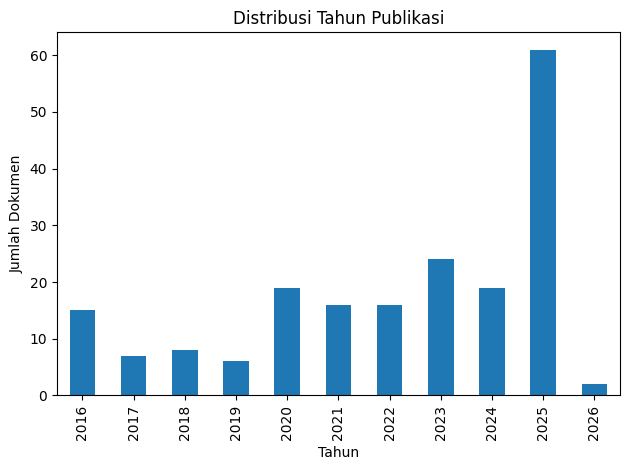

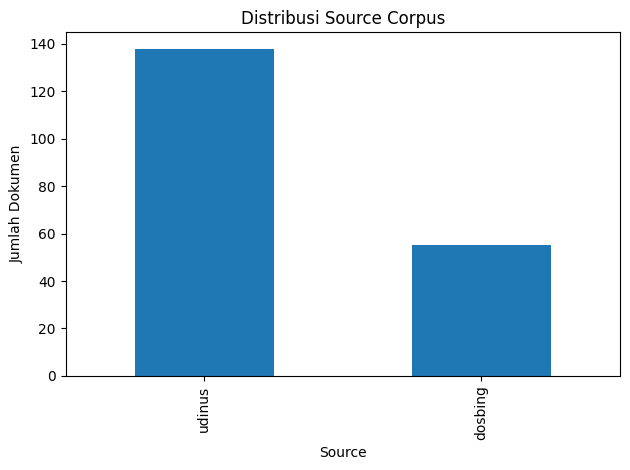

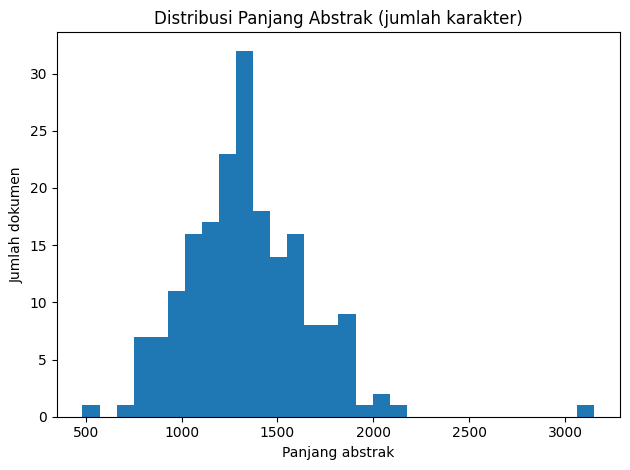

Saved figures in: outputs\figures


In [43]:
# Tahun
years = pd.to_numeric(df["tanggal"].fillna("").astype(str).str.slice(0,4), errors="coerce").dropna().astype(int)

plt.figure()
years.value_counts().sort_index().plot(kind="bar")
plt.title("Distribusi Tahun Publikasi")
plt.xlabel("Tahun")
plt.ylabel("Jumlah Dokumen")
plt.tight_layout()
plt.savefig(FIG_DIR / "year_distribution.png", dpi=200)
plt.show()

# Source
plt.figure()
df["source"].fillna("(null)").value_counts().plot(kind="bar")
plt.title("Distribusi Source Corpus")
plt.xlabel("Source")
plt.ylabel("Jumlah Dokumen")
plt.tight_layout()
plt.savefig(FIG_DIR / "source_distribution.png", dpi=200)
plt.show()

# Panjang abstrak
abs_len = df["abstrak"].fillna("").map(len)
plt.figure()
plt.hist(abs_len, bins=30)
plt.title("Distribusi Panjang Abstrak (jumlah karakter)")
plt.xlabel("Panjang abstrak")
plt.ylabel("Jumlah dokumen")
plt.tight_layout()
plt.savefig(FIG_DIR / "abstract_length_hist.png", dpi=200)
plt.show()

print("Saved figures in:", FIG_DIR)


#### Preprocessing


In [44]:
# ===== 4) Preprocessing =====
# Basic stopwords
STOPWORDS_ID = set([
    "yang","dan","di","ke","dari","pada","untuk","dengan","dalam","atau","sebagai",
    "adalah","ini","itu","oleh","dapat","akan","dalam","terhadap","serta","hasil","penelitian",
    "metode","menggunakan","berbasis","studi","analisis","sistem","aplikasi","data","model",
])

# Akronim/entitas yang mau dipertahankan (upper-case)
ACRONYMS = {
    "ihsg": "IHSG",
    "indeks harga saham gabungan": "IHSG",
    "bbm": "BBM",
    "bahan bakar minyak": "BBM",
    "iot": "IoT",
}

def normalize_acronyms(text: str) -> str:
    if not isinstance(text, str):
        return ""
    t = text
    # replace long forms first
    for k, v in sorted(ACRONYMS.items(), key=lambda x: -len(x[0])):
        pattern = re.compile(r"\b" + re.escape(k) + r"\b", flags=re.IGNORECASE)
        t = pattern.sub(v, t)
    return t

TOKEN_RE = re.compile(r"[A-Za-z0-9]+")

def tokenize(text: str):
    text = normalize_acronyms(text)
    text = text.lower()
    toks = TOKEN_RE.findall(text)
    toks = [t for t in toks if t not in STOPWORDS_ID and len(t) >= 2]
    return toks

def build_doc_text(row) -> str:
    # combine fields (judul + abstrak + keyword)
    parts = []
    for col in ["judul","abstrak","keyword"]:
        val = row.get(col, "")
        if isinstance(val, str) and val.strip():
            parts.append(val.strip())
    return "".join(parts)

# contoh before-after
sample = df.sample(1, random_state=7).iloc[0].to_dict()
raw = build_doc_text(sample)
print("RAW (first 400 chars):")
print(raw[:400])
print("TOKENS (first 40):")
print(tokenize(raw)[:40])


RAW (first 400 chars):
Aplikasi Prediksi Harga Saham Menggunakan Metode Simple Moving Averages Pada Bursa Efek IndonesiaSaham merupakan instrumen pasar keuangan yang paling polular. Menerbitkan sebuah saham adalah salah satu pilihan banyak perusahaan ketika memutuskan menambahkan modal dari perusahaan. Di sisi lainnya, saham adalah sebuah variabel investasi yang paling sering dipilih oleh investor dikarenakan saham dapa
TOKENS (first 40):
['prediksi', 'harga', 'saham', 'simple', 'moving', 'averages', 'bursa', 'efek', 'indonesiasaham', 'merupakan', 'instrumen', 'pasar', 'keuangan', 'paling', 'polular', 'menerbitkan', 'sebuah', 'saham', 'salah', 'satu', 'pilihan', 'banyak', 'perusahaan', 'ketika', 'memutuskan', 'menambahkan', 'modal', 'perusahaan', 'sisi', 'lainnya', 'saham', 'sebuah', 'variabel', 'investasi', 'paling', 'sering', 'dipilih', 'investor', 'dikarenakan', 'saham']


In [45]:
# Apply preprocessing to all docs
df = df.copy()
df["doc_text_raw"] = df.apply(lambda r: build_doc_text(r), axis=1)
df["tokens"] = df["doc_text_raw"].apply(tokenize)
df["doc_text"] = df["tokens"].apply(lambda ts: " ".join(ts))

print("Example doc_text:")
display(df[["doc_id","source","judul","doc_text"]].head(3))

# vocab & token stats
vocab = Counter()
lengths = []
for ts in df["tokens"]:
    vocab.update(ts)
    lengths.append(len(ts))

stats = pd.DataFrame([{
    "vocab_size": len(vocab),
    "avg_tokens_per_doc": float(np.mean(lengths)),
    "median_tokens_per_doc": float(np.median(lengths)),
    "p95_tokens_per_doc": float(np.percentile(lengths, 95)),
}])

display(stats)
stats.to_csv(OUT_DIR / "preprocess_stats.csv", index=False)
print("Saved: preprocess_stats.csv")


Example doc_text:


,doc_id,source,judul,doc_text
0,11531.joins,udinus,Pendekatan Single Page Application pada Sistem Informasi Bimbingan Tugas Akhir Menggunakan Metode Agile Developement,pendekatan single page application informasi bimbingan tugas akhir agile developementpenelitian bertujuan mengembang...
1,1167.joins,udinus,Mitigasi Risiko Aset Dan Komponen Teknologi Informasi Berdasarkan Kerangka Kerja OCTAVE Dan FMEA Pada Universitas Di...,mitigasi risiko aset komponen teknologi informasi berdasarkan kerangka kerja octave fmea universitas dian nuswantoro...
2,1168.joins,udinus,"Analisis Proses Monitoring, Evaluasi dan Penilaian Pengendalian Internal (MEA02) Tata Kelola Teknologi Informasi Ber...",proses monitoring evaluasi penilaian pengendalian internal mea02 tata kelola teknologi informasi berdasarkan kerangk...


,vocab_size,avg_tokens_per_doc,median_tokens_per_doc,p95_tokens_per_doc
0,5381,146.321244,142.0,200.4


Saved: preprocess_stats.csv


#### BM25 (Rekomendasi Sitasi)

In [46]:
# ===== BM25 (Okapi) simple implementation =====
class BM25OkapiSimple:
    def __init__(self, corpus_tokens, k1=1.5, b=0.75):
        self.corpus_tokens = corpus_tokens
        self.k1 = k1
        self.b = b
        self.N = len(corpus_tokens)
        self.doc_len = np.array([len(d) for d in corpus_tokens], dtype=float)
        self.avgdl = float(self.doc_len.mean()) if self.N else 0.0

        # DF
        dfreq = Counter()
        for doc in corpus_tokens:
            dfreq.update(set(doc))
        self.df = dfreq

        # IDF
        self.idf = {}
        for term, df_t in self.df.items():
            # classic BM25 idf
            self.idf[term] = math.log(1 + (self.N - df_t + 0.5) / (df_t + 0.5))

        # TF per doc (Counter)
        self.tf = [Counter(doc) for doc in corpus_tokens]

    def get_scores(self, query_tokens):
        scores = np.zeros(self.N, dtype=float)
        if self.N == 0:
            return scores
        q = [t for t in query_tokens if t in self.idf]
        if not q:
            return scores

        for i in range(self.N):
            dl = self.doc_len[i]
            denom_const = self.k1 * (1 - self.b + self.b * (dl / self.avgdl))
            doc_tf = self.tf[i]
            s = 0.0
            for term in q:
                f = doc_tf.get(term, 0)
                if f == 0:
                    continue
                idf = self.idf.get(term, 0.0)
                s += idf * (f * (self.k1 + 1)) / (f + denom_const)
            scores[i] = s
        return scores

# Build index
corpus_tokens = df["tokens"].tolist()
bm25 = BM25OkapiSimple(corpus_tokens, k1=1.5, b=0.75)
print("BM25 ready. Docs:", len(corpus_tokens))


BM25 ready. Docs: 193


#### Fungsi Search + Evidence Sentence + Highlight


In [47]:
def split_sentences(text: str):
    if not isinstance(text, str):
        return []
    # split sederhana
    sents = re.split(r"(?<=[.!?])\s+", text.strip())
    sents = [s.strip() for s in sents if s.strip()]
    return sents

def best_evidence_sentence(abstract: str, query_tokens):
    sents = split_sentences(abstract)
    if not sents:
        return ""
    qset = set(query_tokens)
    best = ""
    best_score = -1
    for s in sents:
        stoks = tokenize(s)
        overlap = len(qset.intersection(stoks))
        # prefer sentence with more overlap, break ties by length (not too short)
        score = overlap * 10 + min(len(stoks), 30)
        if score > best_score:
            best_score = score
            best = s
    return best

def highlight_terms_html(text: str, terms):
    if not text:
        return ""
    terms = sorted({t for t in terms if isinstance(t, str) and t.strip()}, key=len, reverse=True)
    if not terms:
        return text

    out = text
    for t in terms:
        # highlight case-insensitive whole word
        out = re.sub(
            r"\b(" + re.escape(t) + r")\b",
            r"<b>\1</b>",
            out,
            flags=re.IGNORECASE
        )
    return out

def search_citations(query: str, topn=20):
    q_tokens = tokenize(query)
    scores = bm25.get_scores(q_tokens)
    order = np.argsort(-scores)

    results = []
    for idx in order[:topn]:
        row = df.iloc[int(idx)].to_dict()
        row["bm25_score"] = float(scores[idx])
        row["matched_terms"] = sorted(set(q_tokens).intersection(set(row.get("tokens", []))))
        abs_text = row.get("abstrak") or ""
        ev = best_evidence_sentence(abs_text, q_tokens)
        row["evidence"] = ev
        row["evidence_html"] = highlight_terms_html(ev, row["matched_terms"])
        results.append(row)
    return q_tokens, results

# Demo query
q = "IHSG"
q_tokens, res = search_citations(q, topn=10)
print("Query tokens:", q_tokens)
print("Top 3 titles:")
for r in res[:3]:
    print("-", r.get("judul"), "| score=", round(r["bm25_score"], 4))


Query tokens: ['ihsg']
Top 3 titles:
- Optimasi Investasi di Pasar Saham Indonesia: Meningkatkan Keputusan Investasi dengan Prediksi IHSG menggunakan Decision Tree | score= 7.6576
- Pengukuran Kinerja Pelayanan Implementasi Metode Fuzzy Time Series Terhadap Dampak Perubahan Harga Bahan Bakar Minyak pada Investasi Saham (Studi Peristiwa : Saham pada IHSG di Bursa Efek Indonesia) | score= 7.5911
- Penerapan Metode Clustering Dengan Algoritma K-Means Untuk Rekomendasi Pemilihan Jalur Peminatan Sesuai Kemampuan Pada Progam Studi Teknik Informatika - S1 Universitas Dian Nuswantoro | score= 6.8248


In [48]:
from IPython.display import HTML, display

def show_result_cards(results, n=5):
    for r in results[:n]:
        title = r.get("judul") or "(Tanpa judul)"
        url = r.get("url") or ""
        src = r.get("source")
        tgl = r.get("tanggal")
        score = r.get("bm25_score")
        matched = r.get("matched_terms", [])
        ev_html = r.get("evidence_html", "")

        html = f"""
        <div style='border:1px solid rgba(255,255,255,.12); padding:12px; border-radius:12px; margin:10px 0; background:rgba(255,255,255,.04)'>
          <div style='font-weight:800; font-size:16px; line-height:1.25'>
            {'<a href="'+url+'" target="_blank">'+title+'</a>' if url else title}
          </div>
          <div style='opacity:.75; font-size:12px; margin-top:6px'>
            score: <b>{score:.4f}</b> &nbsp;•&nbsp; {tgl or '-'} &nbsp;•&nbsp; {src or '-'}
          </div>
          <div style='margin-top:8px; font-size:13px'>
            <div style='opacity:.75; font-size:12px'>Abstrak (evidence):</div>
            <div>{ev_html}</div>
          </div>
          <div style='margin-top:8px; font-size:12px; opacity:.75'>Matched terms: {', '.join(matched[:12])}</div>
        </div>
        """
        display(HTML(html))

show_result_cards(res, n=5)


#### Rekomendasi Dosbing (TF-IDF + Cosine)

In [49]:
# filter sumber dosbing
# asumsi: kolom 'dosen' terisi untuk source=dosbing

dos_df = df[df["source"].astype(str).str.lower().eq("dosbing")].copy()
print("Docs (dosbing):", len(dos_df))

if len(dos_df) == 0:
    print("Tidak ada dokumen source=dosbing di parsed_docs.jsonl. Skip bagian ini atau pastikan corpus dosbing masuk.")
else:
    # group by dosen, concat doc_text
    grouped = dos_df.groupby("dosen").agg(
        pub_count=("doc_id", "count"),
        doc_text=("doc_text", lambda s: " ".join([x for x in s if isinstance(x,str)])),
    ).reset_index()

    display(grouped.head(5))

    vectorizer = TfidfVectorizer(
        ngram_range=(1,2),
        min_df=1,
        max_df=0.95,
    )
    X = vectorizer.fit_transform(grouped["doc_text"].fillna(""))

    def recommend_supervisors(query: str, topn=10):
        qt = " ".join(tokenize(query))
        qv = vectorizer.transform([qt])
        sims = cosine_similarity(qv, X).flatten()
        order = np.argsort(-sims)
        out = []
        for i in order[:topn]:
            row = grouped.iloc[int(i)].to_dict()
            row["similarity"] = float(sims[i])
            # matched terms (approx): intersect query tokens with top features in dosen doc
            row["matched_terms"] = sorted(set(tokenize(query)).intersection(set(tokenize(row.get("doc_text","")))))[:12]
            out.append(row)
        return out

    sup_res = recommend_supervisors("prediksi IHSG", topn=5)
    display(pd.DataFrame(sup_res)[["dosen","pub_count","similarity","matched_terms"]])


Docs (dosbing): 55


,dosen,pub_count,doc_text
0,"ABU SALAM, M.Kom",5,peningkatan kesadaran kanker usus siswa smp ibu kartini melalui mobilekanker usus merupakan salah satu penyakit dice...
1,"ARDYTHA LUTHFIARTA, M.Kom",5,pengenalan pola aksara jawa korelasi template matchingpada era modern dampak globalisasi semakin masuk meluas sebagi...
2,"CINANTYA PARAMITA, S.Kom., M.Eng",5,klasifikasi jeruk nipis tingkat kematangan buah berdasarkan fitur warna nearest neighborpada proses klasifikasi buah...
3,"Dr. Amiq Fahmi, S. Kom., M.Kom",5,pendekatan klasterisasi pemetaan rencana kontinjensi denguetujuan epidemi dengue menunjukkan peningkatan jumlah pend...
4,"FAUZI ADI RAFRASTARA, M.CS",5,optimasi investasi pasar saham indonesia meningkatkan keputusan investasi prediksi ihsg decision treepasar saham ind...


,dosen,pub_count,similarity,matched_terms
0,"FAUZI ADI RAFRASTARA, M.CS",5,0.108510,"[ihsg, prediksi]"
1,"CINANTYA PARAMITA, S.Kom., M.Eng",5,0.086572,"[ihsg, prediksi]"
2,"Gustina Alfa Trisnapradika, M.Kom",5,0.047411,[prediksi]
3,"Prof. Dr. RINDRA YUSIANTO, S.Kom, MT",5,0.016046,[prediksi]
4,"ARDYTHA LUTHFIARTA, M.Kom",5,0.008841,[prediksi]


#### Evaluasi

In [66]:
# ===== 7) Evaluation templates =====

# Buat daftar query uji
TEST_QUERIES = [
    "aplikasi prediksi harga saham atau IHSG",
    "rekomendasi sitasi untuk proposal PKM desa wisata",
    "klasifikasi sentimen bahasa indonesia menggunakan SVM",
    "deteksi malware berbasis machine learning",
    "information retrieval bm25 tf-idf untuk pencarian paper",
]

# Ground truth: mapping query -> set doc_id yang dianggap relevan
# Isi ini manual (paling realistis 3-10 doc relevan per query)
GROUND_TRUTH = {
    # "prediksi IHSG": {"1167.joins", "..."},
    "aplikasi prediksi harga saham atau IHSG": {"1173.joins", "1876.jurnalabdimasku", "6193.poltekharber"},
    "rekomendasi sitasi untuk proposal PKM desa wisata": {"1147.jimik", "1876.joins", "4235.jurnalaudience", "3014.jurnalabdimasku"},
    "klasifikasi sentimen bahasa indonesia menggunakan SVM": {"5883.joins", "715.jacost", "11793.technoc"},
    "deteksi malware berbasis machine learning": {"4968857.kemdiktisaintek", "38334.ijeecs", "5207.poltekharber"},
    "information retrieval bm25 tf-idf untuk pencarian paper": {"12873.technoc", "4968857.kemdiktisaintek", "12852.technoc"}
}

def precision_at_k(pred_ids, rel_set, k):
    pred_k = pred_ids[:k]
    if k == 0:
        return 0.0
    return sum(1 for x in pred_k if x in rel_set) / k

def dcg_at_k(pred_ids, rel_set, k):
    dcg = 0.0
    for i, doc_id in enumerate(pred_ids[:k], start=1):
        rel = 1.0 if doc_id in rel_set else 0.0
        dcg += rel / math.log2(i + 1)
    return dcg

def ndcg_at_k(pred_ids, rel_set, k):
    dcg = dcg_at_k(pred_ids, rel_set, k)
    ideal = list(rel_set)[:k]
    idcg = dcg_at_k(ideal, set(ideal), k)
    return (dcg / idcg) if idcg > 0 else 0.0

def evaluate_citations(queries, gt, k=10):
    rows = []
    for q in queries:
        if q not in gt:
            continue
        _, res = search_citations(q, topn=50)
        pred_ids = [r.get("doc_id") for r in res]
        rel_set = gt[q]
        rows.append({
            "query": q,
            f"P@{k}": precision_at_k(pred_ids, rel_set, k),
            f"nDCG@{k}": ndcg_at_k(pred_ids, rel_set, k),
            "n_rel": len(rel_set),
        })
    return pd.DataFrame(rows)

# Jalankan setelah kamu isi GROUND_TRUTH
eval_df = evaluate_citations(TEST_QUERIES, GROUND_TRUTH, k=10)
display(eval_df)


,query,P@10,nDCG@10,n_rel
0,aplikasi prediksi harga saham atau IHSG,0.3,0.946902,3
1,rekomendasi sitasi untuk proposal PKM desa wisata,0.4,0.943866,4
2,klasifikasi sentimen bahasa indonesia menggunakan SVM,0.3,0.901013,3
3,deteksi malware berbasis machine learning,0.3,0.967468,3
4,information retrieval bm25 tf-idf untuk pencarian paper,0.3,0.967468,3


In [68]:
query_for_report = "Malware detection using machine learning"
q_tokens, res = search_citations(query_for_report, topn=20)

out_rows = []
for r in res:
    out_rows.append({
        "doc_id": r.get("doc_id"),
        "judul": r.get("judul"),
        "tanggal": r.get("tanggal"),
        "source": r.get("source"),
        "bm25_score": r.get("bm25_score"),
        "matched_terms": ", ".join(r.get("matched_terms", [])[:12]),
        "evidence": r.get("evidence"),
        "url": r.get("url"),
    })

out_df = pd.DataFrame(out_rows)
display(out_df.head(10))

out_df.to_csv(OUT_DIR / "example_search_IHSG.csv", index=False)
print("Saved:", OUT_DIR / "example_search_IHSG.csv")


,doc_id,judul,tanggal,source,bm25_score,matched_terms,evidence,url
0,4968857.kemdiktisaintek,Model Hybrid Random Forest dan Information Gain untuk meningkatkan Performa Algoritma Machine Learning pada Deteksi ...,2024/09/30,dosbing,15.364607,"learning, machine, malware","Oleh karena itu, diperlukan antivirus cerdas berbasis machine learning yang mampu mendeteksi malware berdasarkan per...",https://publikasiilmiah.unwahas.ac.id/JINRPL/article/download/12638/6175
1,38334.ijeecs,Deteksi Malware Android Menggunakan Fast Correlation Based Filter dan Algoritma Random Forest,2024/09/21,dosbing,14.143186,"learning, machine, malware",Penelitian ini membahas tantangan deteksi malware Android dengan memanfaatkan teknik machine learning tingkat lanjut...,https://ijeecs.iaescore.com/index.php/IJEECS/article/view/38334/18811
2,27495.trunojoyo,Optimasi Model Machine Learning Untuk Prediksi Inhibitor Korosi Berbasis Augmentasi Dataset Senyawa N-Heterocyclic M...,2025/05/20,dosbing,7.784003,"learning, machine","Model machine learning linier (MLR, Ridge, Lasso, dan ElasticNet) serta non-linier (KNR, Random Forest, Gradient Boo...",https://journal.trunojoyo.ac.id/nero/article/viewFile/27945/10952
3,256.ijmnt,Perbandingan Algoritma Machine Learning Linier dan Non-Linier untuk Memprediksi Efektivitas Ekstrak Tumbuhan sebagai...,2024/07/15,dosbing,7.447430,"learning, machine",Penelitian ini bertujuan untuk mengembangkan model Machine Learning (ML) guna memprediksi secara akurat potensi inhi...,https://ejournals.umn.ac.id/index.php/IJNMT/issue/download/256/IJNMT%20June%202024#page=14
4,5207.poltekharber,Peningkatan Kinerja Algoritma Random Forest untuk Deteksi Malware pada Dataset Tidak Seimbang Menggunakan Metode Ran...,2023/05/30,dosbing,7.242677,malware,"Dalam kasus deteksi malware, nilai false negative sangat krusial karena dapat berakibat fatal, sehingga kesalahan pr...",https://ejournal.poltekharber.ac.id/index.php/informatika/article/download/5207/2435
5,11730.technoc,Optimasi Prediksi Prediabetes dengan Metode Fitur Selection dan Imbalance Learning,2025/02/26,udinus,7.176852,"learning, machine",Penelitian ini menggabungkan analisis korelasi variabel dan metode imbalance learning untuk mengoptimalkan prediksi ...,https://publikasi.dinus.ac.id/technoc/article/view/11730/5105
6,12955.technoc,Model Deteksi Tutupan Lahan di Kecamatan Gunungsitoli Menggunakan Algoritma Decision Tree Berbasis Machine Learning,2025/08/18,udinus,7.007420,"learning, machine",Integrasi data penginderaan jauh dan Artificial Intelligence - Machine Learning menjadi pendekatan yang sangat efisi...,https://publikasi.dinus.ac.id/technoc/article/view/12955/5493
7,4917737.researchsquare,Pendekatan Machine Learning Untuk Memprediksi Efektivitas Inhibitor Korosi Piridazin,2024/09/13,dosbing,6.636036,"learning, machine",Makalah ini menyajikan metodologi machine learning (ML) yang berlandaskan prinsip quantitative structure–property re...,https://assets-eu.researchsquare.com/files/rs-4917737/v1/73999e65-7a0c-45e4-bfaa-e0dfd060697e.pdf?c=1733761075
8,11928.technoc,Sistem Personalisasi Pasien Diabetes Berbasis Domain Fitur Menggunakan Algoritma Gradient Boosting Machine,2025/02/26,udinus,6.322836,"learning, machine","Pendekatan berbasis Machine Learning telah banyak digunakan untuk penanganan penyakit diabetes, baik untuk deteksi d...",https://publikasi.dinus.ac.id/technoc/article/view/11928/5102
9,12057.technoc,Evaluasi Performa XGBoost dengan Oversampling dan Hyperparameter Tuning untuk Prediksi Alzheimer,2025/02/26,udinus,6.156623,"learning, machine",Salah satu tantangan utama dalam penerapan machine learning untuk mendeteksi Alzheimer adalah ketidakseimbangan data...,https://publikasi.dinus.ac.id/technoc/article/view/12057/5100


Saved: outputs\example_search_IHSG.csv
